# Implementasjon av ARIMA-modell for Spiller1
#### I dette oppsettet og implementasjon av modellen er det hentet en del inspirasjon fra følgende side:
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [1]:
# Importer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn import metrics
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

import warnings

warnings.filterwarnings("ignore")

# Steg 1: Importere datasettet
#### Bruker datasettet til én av de fire spillerne vi har valgt ut:

In [2]:
data = pd.read_csv('../../Spiller1.csv')
data

,Date,Fatigue,Mood,Readiness,Sleep Durhation,Sleep Quality,Soreness,Stress
0,2020-03-20,3.0,3.0,7.0,9.0,3.0,3.0,2.0
1,2020-03-21,3.0,3.0,6.0,8.0,3.0,2.0,3.0
2,2020-03-22,3.0,3.0,6.0,9.0,3.0,3.0,4.0
3,2020-03-23,3.0,3.0,7.0,9.0,4.0,3.0,3.0
4,2020-03-24,3.0,3.0,6.0,9.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...
647,2021-12-27,2.0,3.0,3.0,8.0,2.0,2.0,3.0
648,2021-12-28,2.0,3.0,4.0,570.0,4.0,3.0,3.0
649,2021-12-29,3.0,3.0,5.0,8.0,3.0,3.0,3.0
650,2021-12-30,3.0,3.0,5.0,9.0,3.0,3.0,3.0


# Steg 2:  Etter at dataen er importert, må den prepareres
#### Her velger vi ut kun 'Readiness' som parameter, og tar med oss datoene i tillegg.
#### Deretter vil vi konvertere 'Date'-kolonnen til datetime, og setter videre dette som index. For sikkerhets skyld
#### blir frekvensen satt til 'D' (daglig).

In [3]:
data = data[['Date', 'Readiness']]

In [4]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.set_index('Date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('D')
data = data.sort_index()
data.head()

,Readiness
Date,
2020-03-20,7.0
2020-03-21,6.0
2020-03-22,6.0
2020-03-23,7.0
2020-03-24,6.0


# Steg 3: Størrelse på datasett
#### Datsettet avgrensens til å være fra 21.03.2020 til 31.12.2021. Gjøres likt hos alle fire spillere sine datasett.

In [5]:
data = (data.loc['2020-03-21':'2021-12-31'])

In [6]:
data['Readiness'] = data['Readiness'].fillna(method='ffill')

# Steg 4: Analysering av datasett
### Fremstiller tidsserien på tre ulike måter i tillegg til fremstilling av ordinært datasett. Ser om det er tilfeller av trender og sesongmessige forhold, som gjør at vi må ta en avgjørelse på om tidsserien behøver å transformeres.

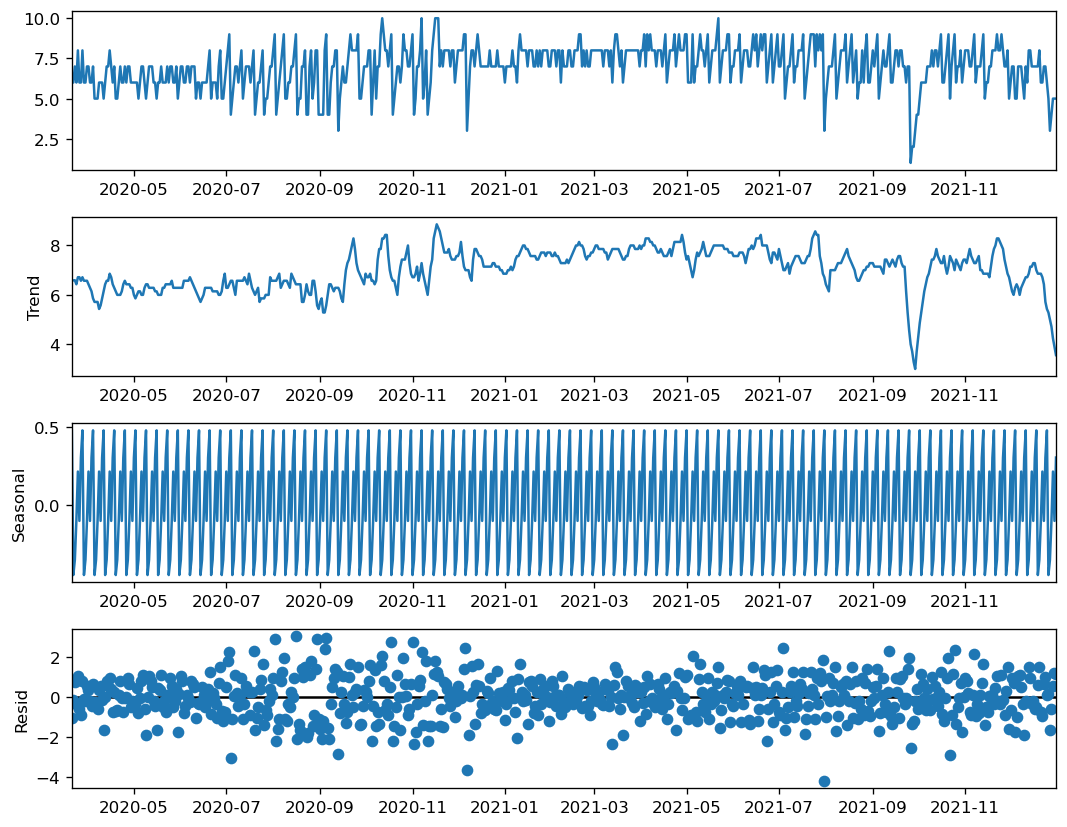

In [7]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive',
                                         extrapolate_trend='freq') 
fig = decomposition.plot()
plt.show()

# Steg 5: Analyserer og finner variabel p, som angir graden for AR(p)
### Ser på partial autocorrelation mellom tidsserien og en gitt lag-verdi.

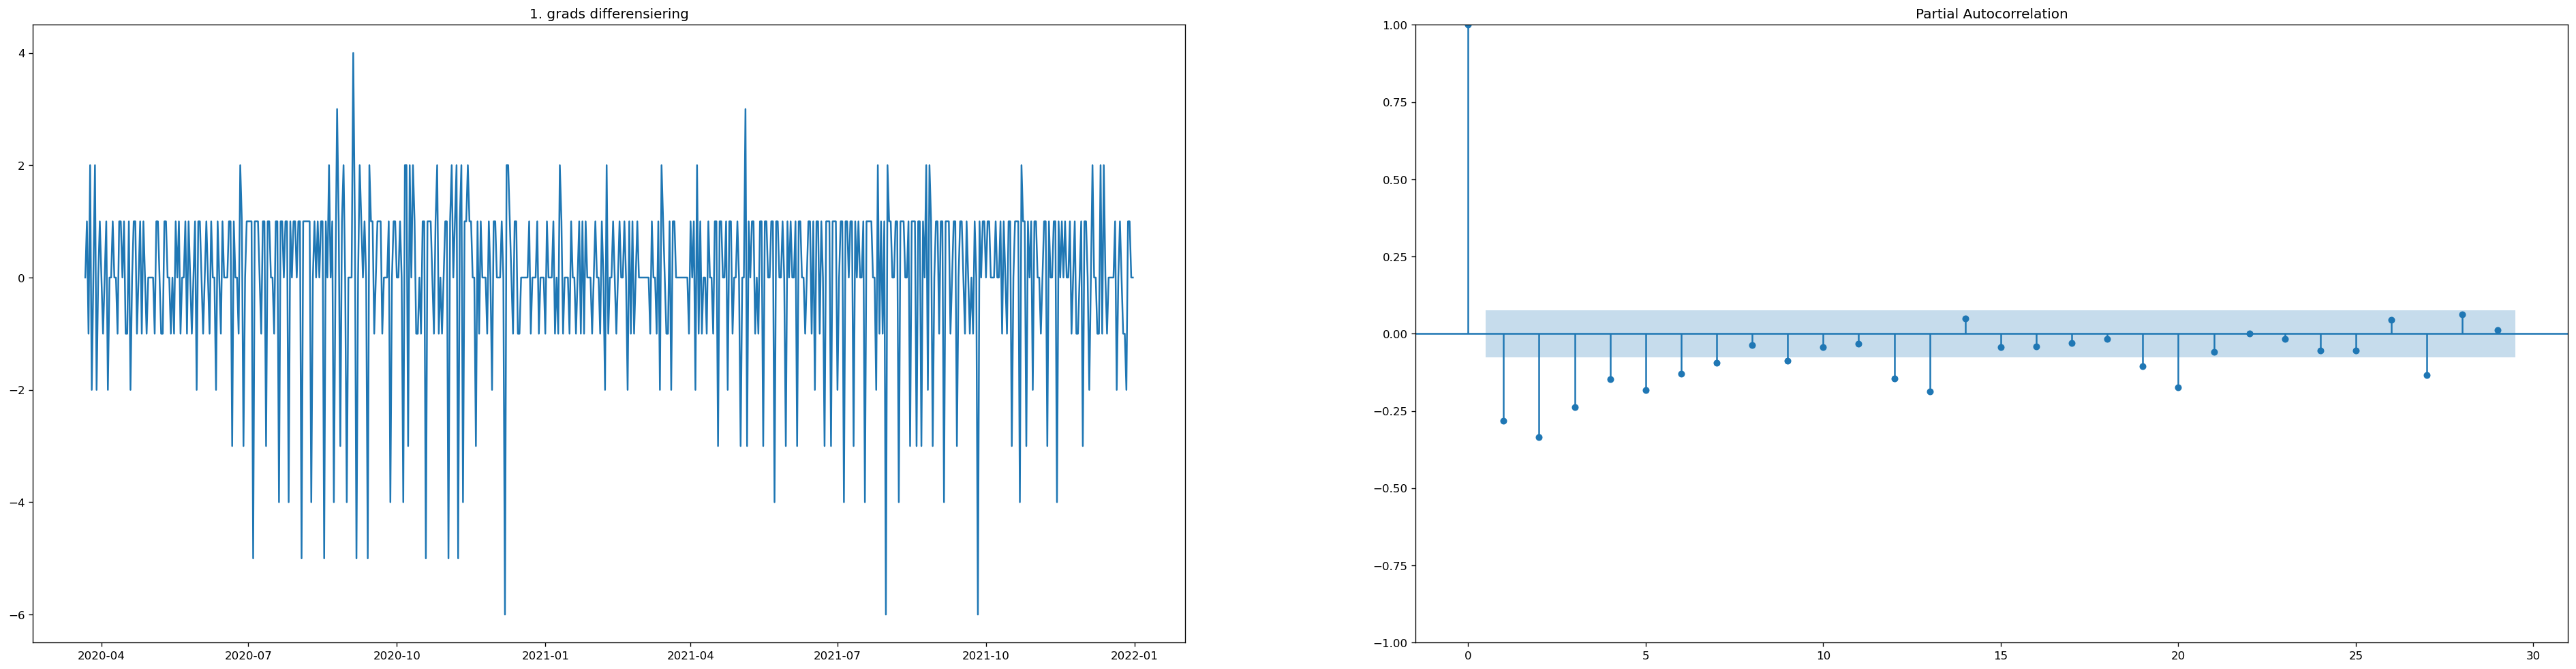

In [8]:
# PACF-plot av tidssserien og 1. grads differensiering
plt.rcParams.update({'figure.figsize':(40,10), 'figure.dpi':120})

fig, axes = plt.subplots(1,2)
axes[0].plot(data.diff()); axes[0].set_title('1. grads differensiering');
axes[1].set_ylim(0,5)
plot_pacf(data.diff().dropna(), ax=axes[1])
plt.show()

### Ser at første lag er veldig høy, og resten er under terskelverdien (det blå området). Dette gir en indikasjon på at variabel p kan ha 1 som en optimal verdi. Andre verdier vil også testes ut. 

# Steg 6: Analyserer å forsøker å finne en optimal verdi for q, som angir graden for MA(q)
#### Ser på autocorrelation for å finne en optimal verdi. AFC skal fortelle oss hvor stor grad av q som behøves for å fjerne eventuell autocorrelation i den stasjonære tidsserien. 

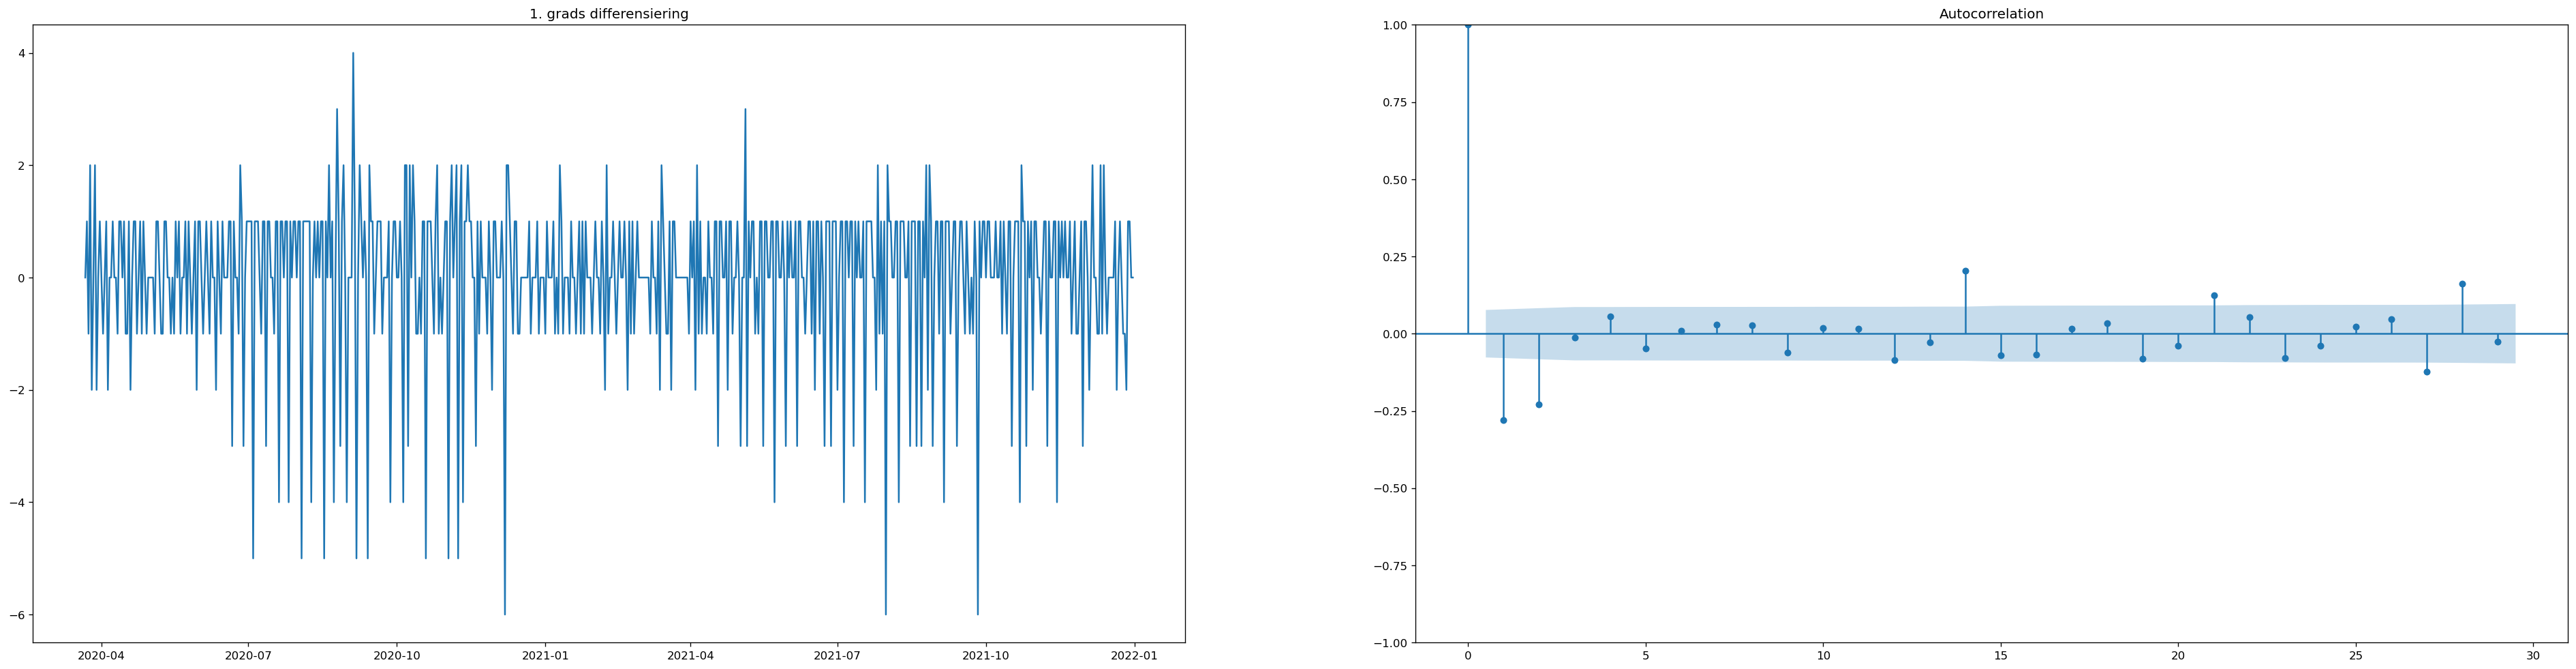

In [9]:
fig, axes = plt.subplots(1,2)
axes[0].plot(data.diff()); axes[0].set_title('1. grads differensiering')
axes[1].set_ylim(0,1.2)
plot_acf(data.diff().dropna(), ax=axes[1])

plt.show()

### Ser at første lag er langt over det blå terskelområdet, og tenker at dette gir en indikasjon på at q har 1 som optimal verdi. Andre verdier vil også testes ut. 

# Steg 7: Bruker en SARIMAX-modell til å teste optimale verdier
#### Her forsøker vi å mate inn de parametrene for (p, d, q) som vi tenker er optimale for å gi en god prediksjonsmodell i ARIMA. Auto-ARIMA har blitt gjennomført på forhånd, og det viste seg til slutt at de verdiene vi fikk presentert her var de mest optimale ut i fra resultatene vi fikk fra SARIMAX-testen. Det er disse verdiene som er implementert i SARIMAX og videre eksperimentering.

In [10]:
model = ARIMA(data, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Readiness   No. Observations:                  651
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1016.863
Date:                Sun, 22 May 2022   AIC                           2047.726
Time:                        19:44:09   BIC                           2079.065
Sample:                    03-21-2020   HQIC                          2059.882
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1213      0.040     -3.025      0.002      -0.200      -0.043
ar.L2         -0.8419      0.017    -48.770      0.000      -0.876      -0.808
ar.L3          0.3210      0.038      8.553      0.0

<AxesSubplot:title={'center':'Prediksjon'}, xlabel='Date'>

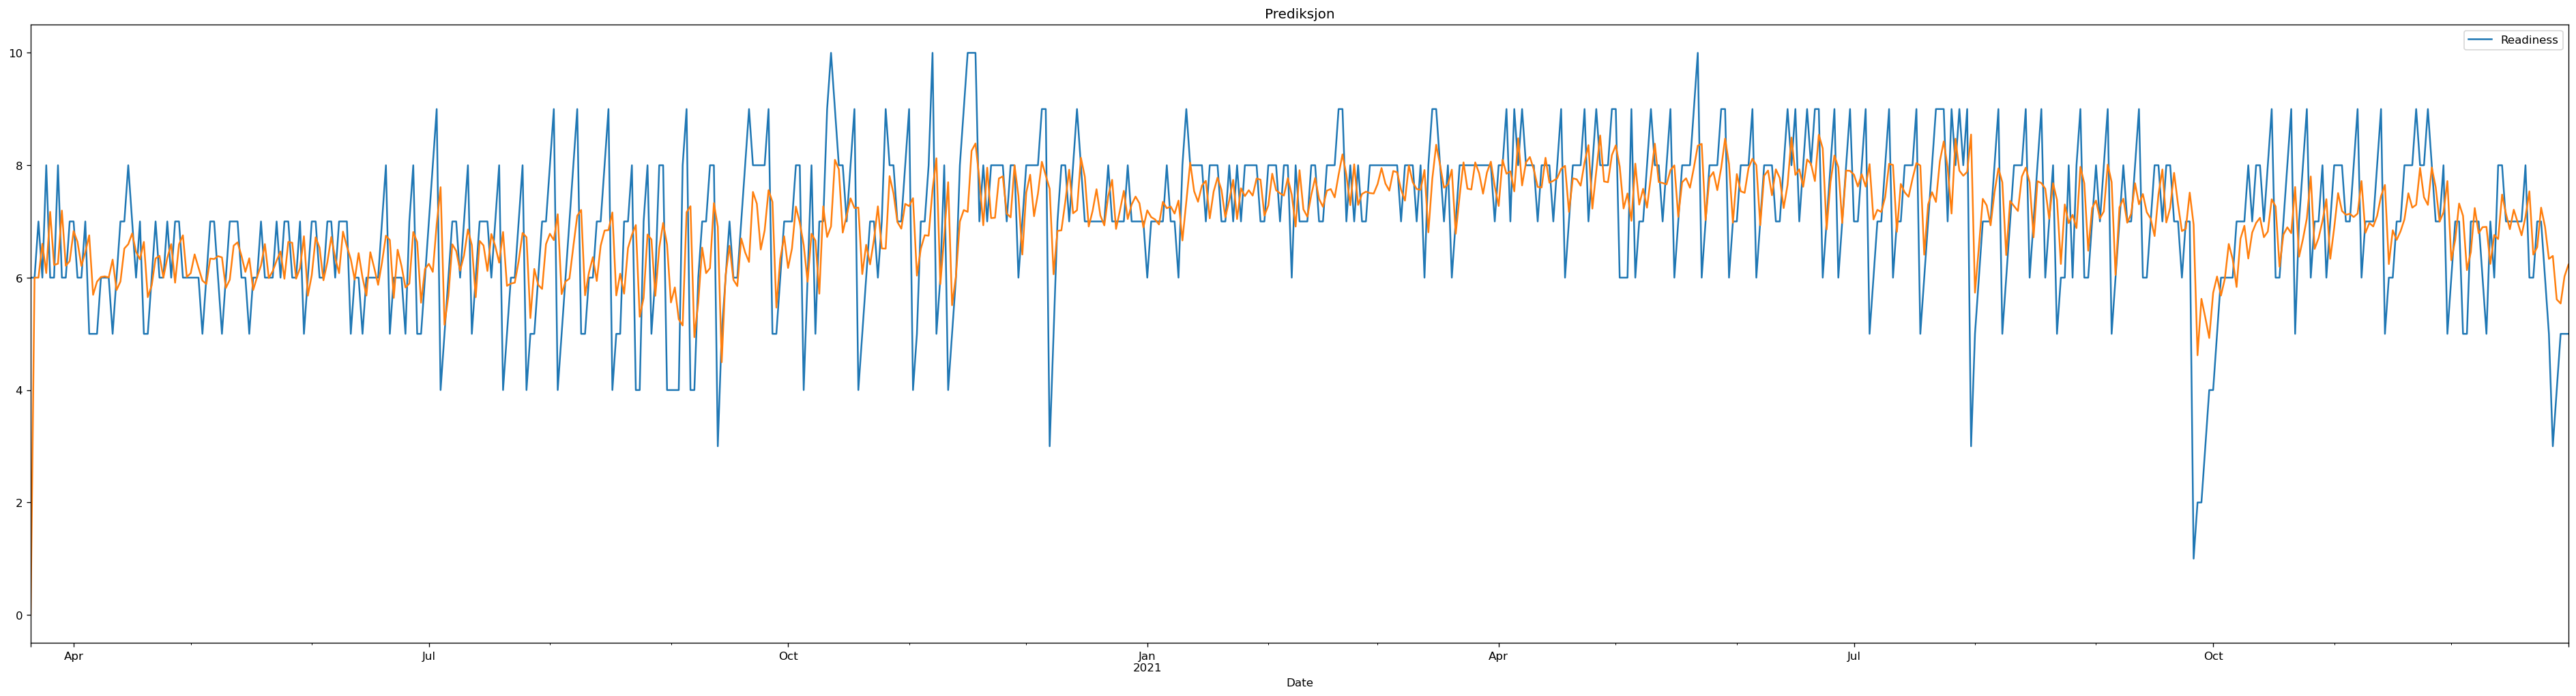

In [11]:
# Plot med faktiske verdier sammen med foreløpig prediksjon
ax = data.plot(title='Original tidsserie')
model_fit.predict(dynamic=False).plot(ax=ax, title='Prediksjon')

# Steg 7: Deler inn i trening- og testsett
### Fordelingen er følgende: Datasettene består av totalt 651 verdier, hvor 80% av disse skal brukes til trening og 20% skal brukes til test og prediksjon. Dette gir oss følgende:
#### Treningssett: 520 verdier
#### Testsett: 131 verdier

In [12]:
train = data[:520]
test = data[520:]

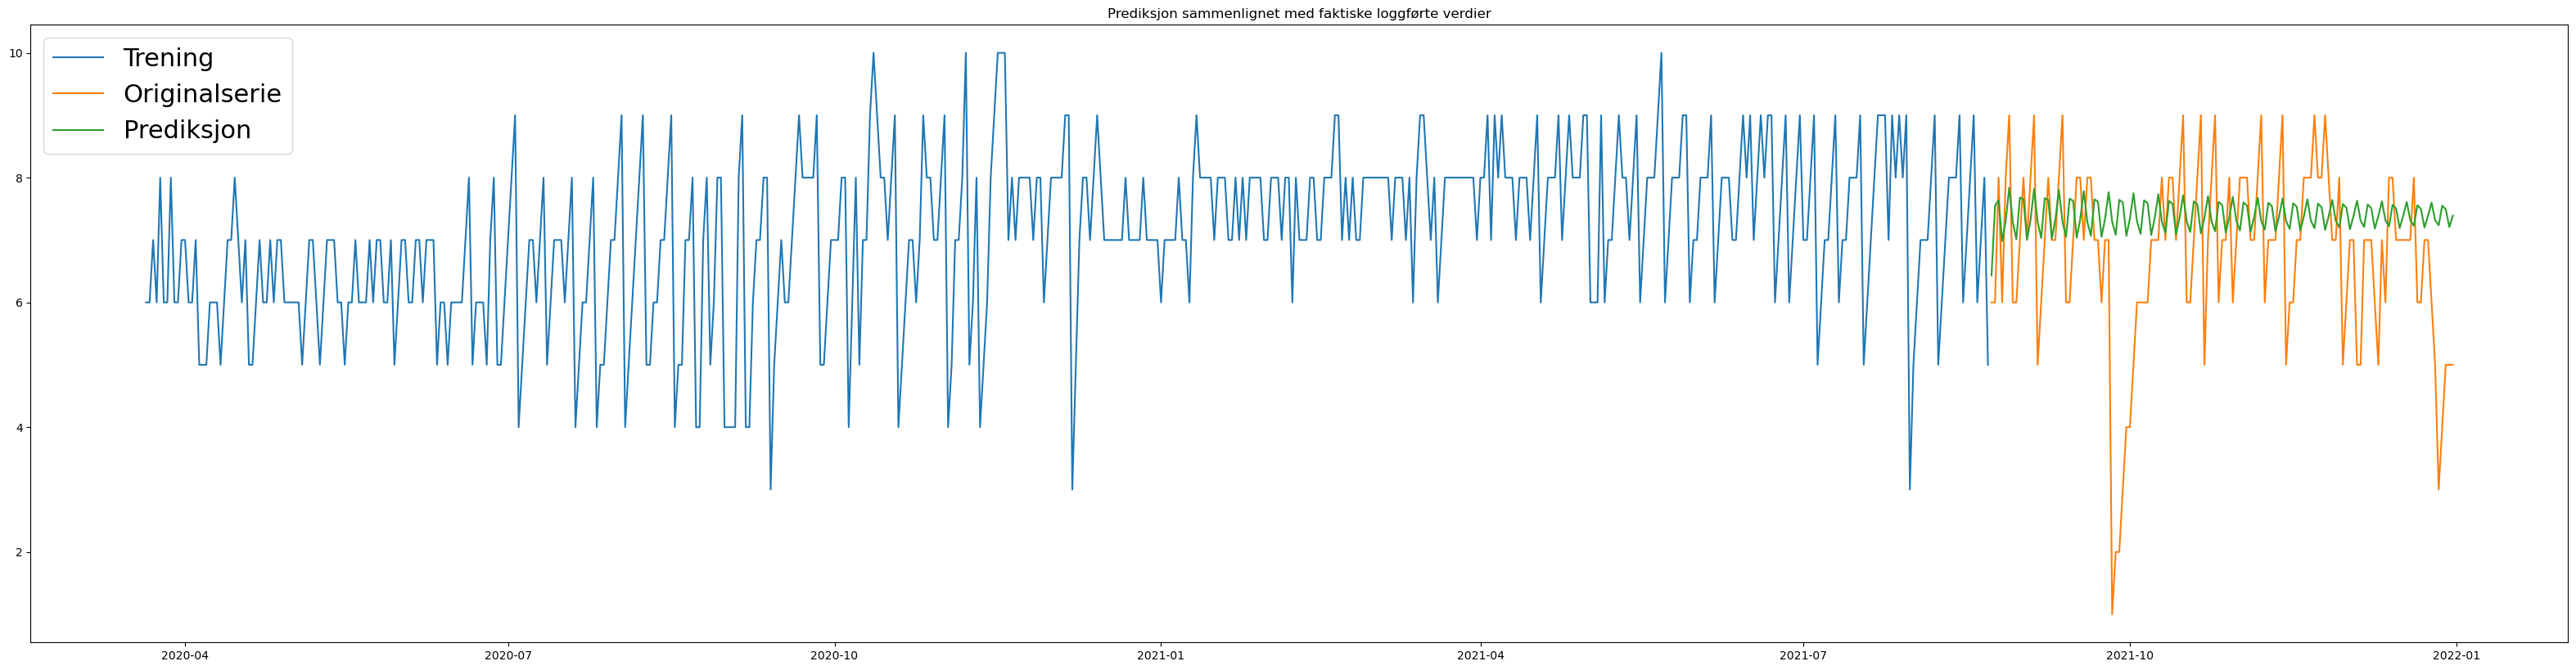

In [13]:
# (1, 1, 1), verdier fra vurderingene gjort av manuelle tester. Gir god testscore, men er i bunn og grunn kun et
# utregnet konstant gjennomsnitt.
# Beste resultater fås med sammensetningen (3, 1, 3)
model = ARIMA(train, order=(3,1,3))
fitted = model.fit()

# Forecast
fc = fitted.forecast(131, alpha=0.05) #95% conf
se = fitted.forecast(131, alpha=0.05) #95% conf
conf = fitted.forecast(131, alpha=0.05) #95% conf

# Make as pandas seires
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf, index=test.index)
upper_series = pd.Series(conf, index=test.index)


# Plot
plt.figure(figsize=(40,10), dpi=100)
plt.plot(train, label='Trening')
plt.plot(test, label='Originalserie')
plt.plot(fc_series, label='Prediksjon')
plt.fill_between(lower_series.index, lower_series, upper_series,
                color='grey', alpha=.15)
plt.title('Prediksjon sammenlignet med faktiske loggførte verdier')
plt.legend(loc='upper left', fontsize=22)
plt.show()


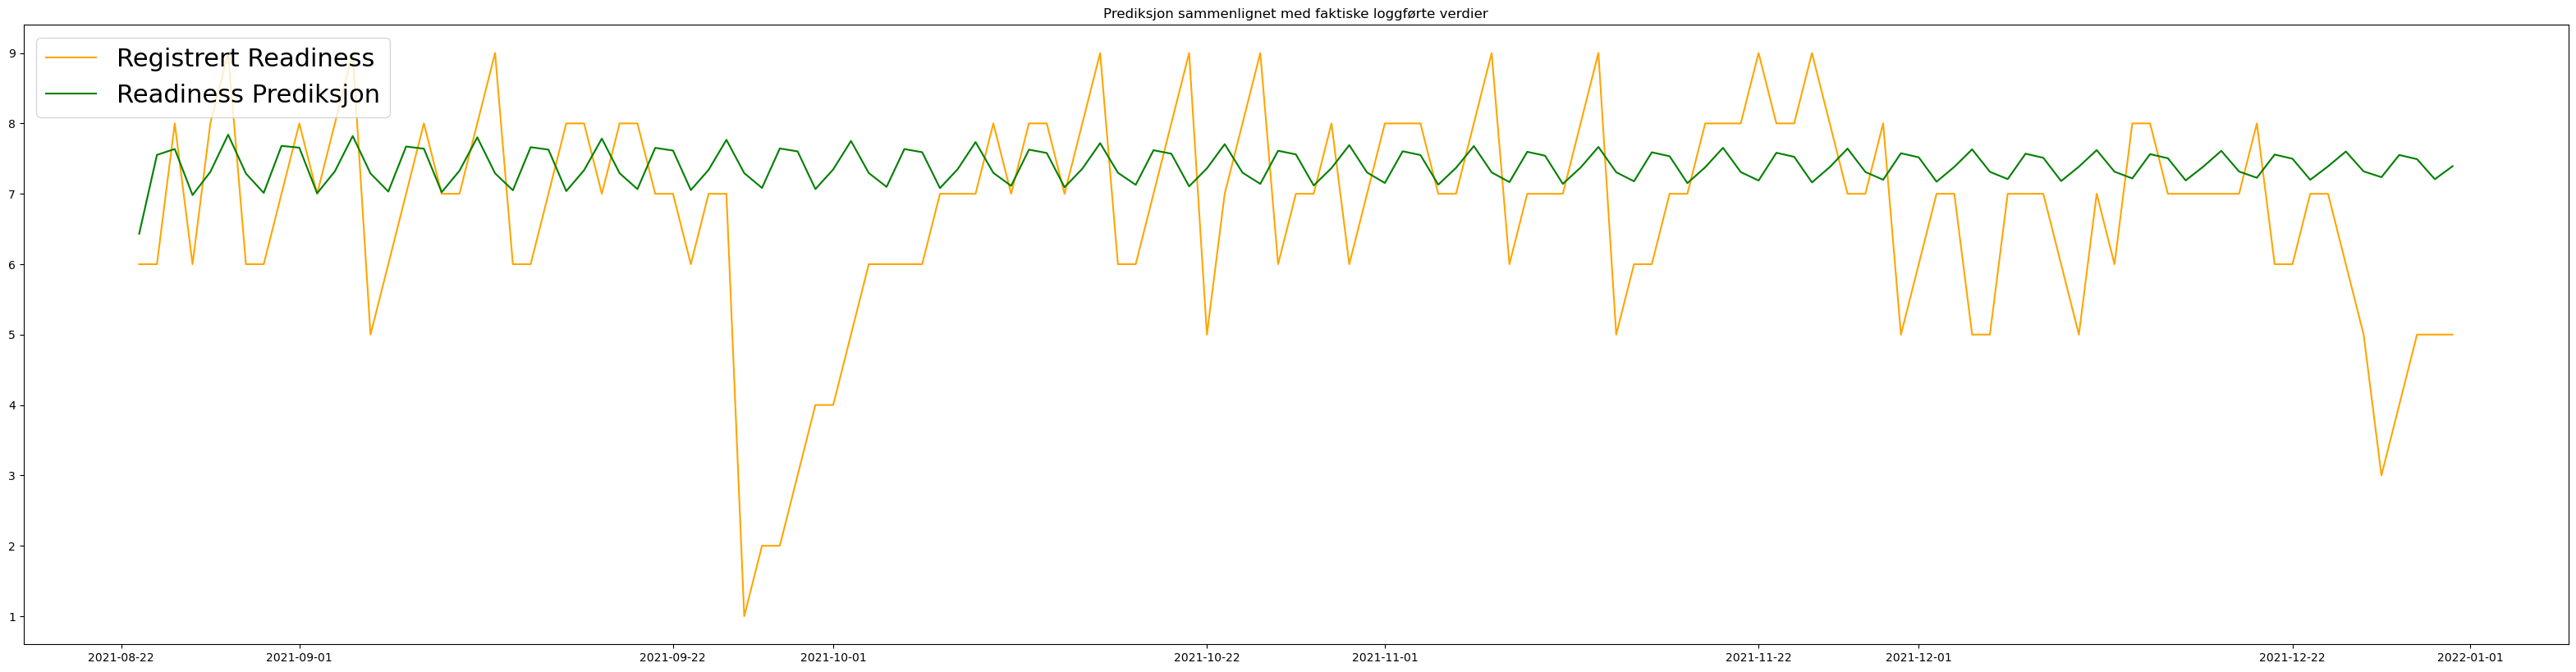

In [14]:
plt.figure(figsize=(40,10), dpi=100)
plt.plot(test, label='Registrert Readiness', color='orange')
plt.plot(fc_series, label='Readiness Prediksjon', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series,
                color='grey', alpha=.15)
plt.title('Prediksjon sammenlignet med faktiske loggførte verdier')
plt.legend(loc='upper left', fontsize=22)
plt.show()

## Faktiske loggførte verdier for Readiness to Play

In [15]:
test.head(10)

,Readiness
Date,
2021-08-23,6.0
2021-08-24,6.0
2021-08-25,8.0
2021-08-26,6.0
2021-08-27,8.0
2021-08-28,9.0
2021-08-29,6.0
2021-08-30,6.0
2021-08-31,7.0


## Predikerte verdier for Readiness to Play

In [16]:
fc_series.head(10)

Date
2021-08-23    6.431340
2021-08-24    7.552822
2021-08-25    7.636453
2021-08-26    6.982605
2021-08-27    7.311344
2021-08-28    7.840267
2021-08-29    7.287830
2021-08-30    7.013124
2021-08-31    7.681076
2021-09-01    7.655354
Freq: D, Name: predicted_mean, dtype: float64

In [17]:
print('---- Oversikt over testscore for Spiller1: ----')
print('')

# Skriver ut RMSE

# Skriver ut MAE 
print('MAE:', metrics.mean_absolute_error(test, fc_series))

# Skriver ut MSE
print('MSE:', metrics.mean_squared_error(test, fc_series))

print('R^2:', metrics.r2_score(test, fc_series))

---- Oversikt over testscore for Spiller1: ----

MAE: 1.1503624883423924
MSE: 2.54790725797423
R^2: -0.17665867745144648
